In [1]:
from google.colab import files 
uploaded = files.upload()

Saving BSE-200.BO.csv to BSE-200.BO.csv


In [3]:
from google.colab import files 
uploaded = files.upload()

Saving india-news-headlines.csv to india-news-headlines.csv


In [59]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [60]:
# reading the datasets into pandas
stock_price = pd.read_csv('BSE-200.BO.csv')

In [61]:
stock_headlines = pd.read_csv('india-news-headlines.csv')


In [62]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-07-16,6932.689941,6936.319824,6908.790039,6925.299805,6925.299805,200
1,2021-07-19,6869.140137,6896.799805,6835.879883,6858.220215,6858.220215,200
2,2021-07-20,6844.930176,6850.799805,6774.450195,6800.640137,6800.640137,100
3,2021-07-22,6841.430176,6891.859863,6839.649902,6887.149902,6887.149902,200
4,2021-07-23,6909.100098,6916.009766,6866.720215,6897.569824,6897.569824,300


In [63]:
len(stock_price), len(stock_headlines)

(249, 3650970)

In [64]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

Stock Prices

In [65]:
#dropping any null entries in our data
stock_price.dropna(axis=0, inplace=True)

In [66]:
# dropping duplicates in data
stock_price = stock_price.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# filtering the important columns
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# sorting the data according to Date
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2021-07-16,6925.299805,6932.689941,6936.319824,6908.790039,200
2021-07-19,6858.220215,6869.140137,6896.799805,6835.879883,200
2021-07-20,6800.640137,6844.930176,6850.799805,6774.450195,100
2021-07-22,6887.149902,6841.430176,6891.859863,6839.649902,200
2021-07-23,6897.569824,6909.100098,6916.009766,6866.720215,300
...,...,...,...,...,...
2022-07-11,7063.229980,7017.740234,7075.200195,7002.350098,100
2022-07-12,7007.950195,7043.069824,7053.620117,6999.020020,100
2022-07-13,6976.109863,7047.029785,7049.700195,6969.549805,100


Stock Headlines

In [67]:
# dropping duplicates
stock_headlines = stock_headlines.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# filtering the important columns 
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
stock_headlines.set_index('publish_date', inplace= True)

# sorting the data according to the Date
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


Combining both Prices and Headlines

In [68]:
# concatenation of the datasets stock_price and stock_headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)

# displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2021-07-16,6925.299805,6932.689941,6936.319824,6908.790039,200.0,Horoscope Today; 16 July 2021: Check astrologi...
2021-07-19,6858.220215,6869.140137,6896.799805,6835.879883,200.0,Understanding the workings of a High Risk Preg...
2021-07-20,6800.640137,6844.930176,6850.799805,6774.450195,100.0,UP's first govt institute of hotel mgmnt to co...
2021-07-22,6887.149902,6841.430176,6891.859863,6839.649902,200.0,Anti-trafficking bill fails to address online ...
2021-07-23,6897.569824,6909.100098,6916.009766,6866.720215,300.0,Horoscope Today; 23 July 2021: Check astrologi...
...,...,...,...,...,...,...
2022-03-25,7412.270020,7461.450195,7465.560059,7378.049805,200.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,7430.959961,7427.410156,7436.229980,7345.729980,100.0,As fashion becomes democratic; demand for styl...
2022-03-29,7475.740234,7461.160156,7481.109863,7439.049805,200.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,7546.779785,7523.140137,7559.189941,7505.080078,200.0,"I will not give in to trends: Dossmode,The tim..."


In [69]:
#Sentiment Analysis
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2021-07-16,6925.299805,6932.689941,6936.319824,6908.790039,200.0,Horoscope Today; 16 July 2021: Check astrologi...,,,,
2021-07-19,6858.220215,6869.140137,6896.799805,6835.879883,200.0,Understanding the workings of a High Risk Preg...,,,,
2021-07-20,6800.640137,6844.930176,6850.799805,6774.450195,100.0,UP's first govt institute of hotel mgmnt to co...,,,,
2021-07-22,6887.149902,6841.430176,6891.859863,6839.649902,200.0,Anti-trafficking bill fails to address online ...,,,,
2021-07-23,6897.569824,6909.100098,6916.009766,6866.720215,300.0,Horoscope Today; 23 July 2021: Check astrologi...,,,,


In [70]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
print('Compound Done')
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
print('Neutral Done')
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2021-07-16,6925.299805,6932.689941,6936.319824,6908.790039,200.0,Horoscope Today; 16 July 2021: Check astrologi...,-0.9999,0.142,0.790,0.068
2021-07-19,6858.220215,6869.140137,6896.799805,6835.879883,200.0,Understanding the workings of a High Risk Preg...,-0.9999,0.139,0.792,0.070
2021-07-20,6800.640137,6844.930176,6850.799805,6774.450195,100.0,UP's first govt institute of hotel mgmnt to co...,-0.9999,0.138,0.783,0.079
2021-07-22,6887.149902,6841.430176,6891.859863,6839.649902,200.0,Anti-trafficking bill fails to address online ...,-0.9999,0.136,0.791,0.073
2021-07-23,6897.569824,6909.100098,6916.009766,6866.720215,300.0,Horoscope Today; 23 July 2021: Check astrologi...,-0.9999,0.147,0.795,0.057


In [71]:
# dropping unwanted 'headline_text' and rearranging columns
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2021-07-16,6925.299805,-0.9999,0.142,0.790,0.068,6932.689941,6936.319824,6908.790039,200.0
2021-07-19,6858.220215,-0.9999,0.139,0.792,0.070,6869.140137,6896.799805,6835.879883,200.0
2021-07-20,6800.640137,-0.9999,0.138,0.783,0.079,6844.930176,6850.799805,6774.450195,100.0
2021-07-22,6887.149902,-0.9999,0.136,0.791,0.073,6841.430176,6891.859863,6839.649902,200.0
2021-07-23,6897.569824,-0.9999,0.147,0.795,0.057,6909.100098,6916.009766,6866.720215,300.0


Feature engineering of the Combined Data

In [72]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [73]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,7467.936818,-0.977034,0.131926,0.792091,0.076017,7477.054061,7509.988914,7421.110967,178.977273
std,291.071479,0.212345,0.016792,0.020722,0.011139,298.103558,293.224464,294.395832,91.095426
min,6800.640137,-0.999900,0.078000,0.743000,0.051000,6826.930176,6850.799805,6756.430176,0.000000
25%,7277.047485,-0.999900,0.119000,0.777000,0.069000,7273.629883,7327.284912,7229.319824,100.000000
50%,7497.034912,-0.999800,0.134000,0.790000,0.076000,7517.239990,7545.345215,7460.879882,200.000000
75%,7695.647339,-0.999700,0.143000,0.805250,0.083000,7693.475097,7729.140137,7640.474976,200.000000
max,8024.899902,0.999800,0.168000,0.857000,0.124000,8080.390137,8081.790039,8018.560059,600.000000


In [74]:
# displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 176 entries, 2021-07-16 to 2022-03-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     176 non-null    float64
 1   compound  176 non-null    float64
 2   negative  176 non-null    float64
 3   neutral   176 non-null    float64
 4   positive  176 non-null    float64
 5   Open      176 non-null    float64
 6   High      176 non-null    float64
 7   Low       176 non-null    float64
 8   Volume    176 non-null    float64
dtypes: float64(9)
memory usage: 13.8 KB


Stock Data Analysis

Text(0, 0.5, 'Close Price (INR)')

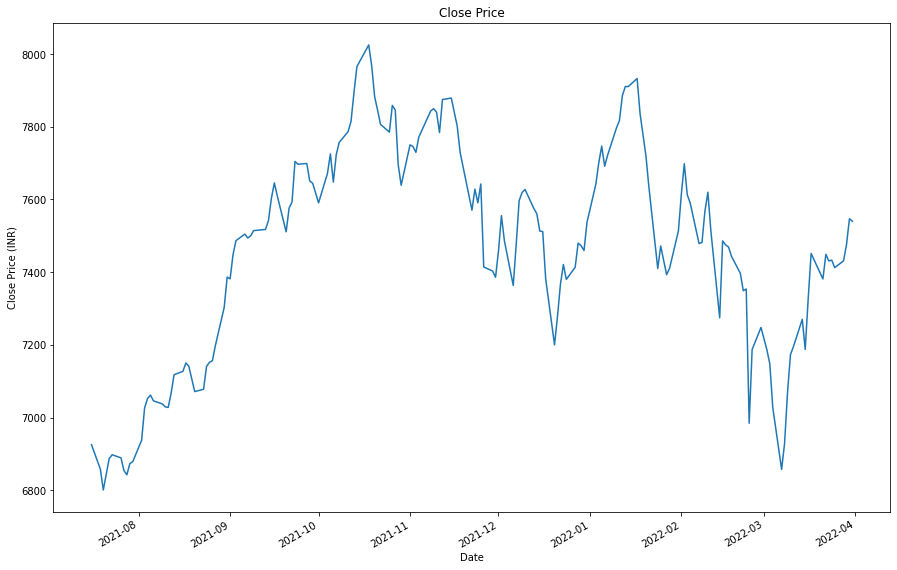

In [75]:
#Setting plot size and labels
plt.figure(figsize=(15,10))

stock_data['Close'].plot()


plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [76]:
# calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2021-07-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-27,6873.124303,-0.999886,0.140286,0.787714,0.072143,6887.365793,6903.689872,6848.001465,171.428571
2021-07-28,6861.304339,-0.999886,0.142857,0.784857,0.072429,6878.632952,6894.438477,6826.235770,157.142857
2021-07-29,6863.455706,-0.999886,0.144857,0.781143,0.074000,6879.331473,6893.119908,6829.388672,157.142857
2021-07-30,6874.612863,-0.999857,0.141286,0.786714,0.072143,6885.809989,6902.799944,6842.492955,157.142857


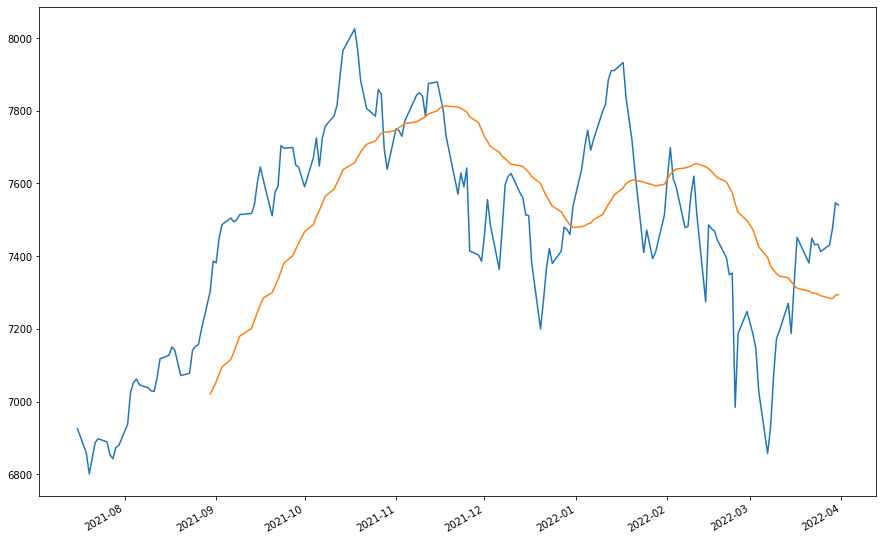

In [77]:
# setting figure size
plt.figure(figsize=(15,10))

# plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [78]:
# displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2021-07-16,6925.299805,-0.9999,0.142,0.790,0.068,6932.689941,6936.319824,6908.790039,200.0
2021-07-19,6858.220215,-0.9999,0.139,0.792,0.070,6869.140137,6896.799805,6835.879883,200.0
2021-07-20,6800.640137,-0.9999,0.138,0.783,0.079,6844.930176,6850.799805,6774.450195,100.0
2021-07-22,6887.149902,-0.9999,0.136,0.791,0.073,6841.430176,6891.859863,6839.649902,200.0
2021-07-23,6897.569824,-0.9999,0.147,0.795,0.057,6909.100098,6916.009766,6866.720215,300.0
...,...,...,...,...,...,...,...,...,...
2022-03-25,7412.270020,-0.9999,0.160,0.774,0.066,7461.450195,7465.560059,7378.049805,200.0
2022-03-28,7430.959961,-0.9999,0.151,0.763,0.086,7427.410156,7436.229980,7345.729980,100.0
2022-03-29,7475.740234,-0.9998,0.131,0.789,0.080,7461.160156,7481.109863,7439.049805,200.0
2022-03-30,7546.779785,-0.9999,0.130,0.806,0.063,7523.140137,7559.189941,7505.080078,200.0


DATA FOR MODELLING

In [79]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 140
Number of records in Test Data: 36


In [80]:
# predicting one step ahead
steps_to_predict = 1


close_price = stock_data.iloc[start:total_data,0] #close
compound = stock_data.iloc[start:total_data,1] #compound
negative = stock_data.iloc[start:total_data,2] #neg
neutral = stock_data.iloc[start:total_data,3] #neu
positive = stock_data.iloc[start:total_data,4] #pos
open_price = stock_data.iloc[start:total_data,5] #open
high = stock_data.iloc[start:total_data,6] #high
low = stock_data.iloc[start:total_data,7] #low
volume = stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

Close Price:


2021-07-19    6858.220215
2021-07-20    6800.640137
2021-07-22    6887.149902
2021-07-23    6897.569824
2021-07-26    6889.060059
                 ...     
2022-03-25    7412.270020
2022-03-28    7430.959961
2022-03-29    7475.740234
2022-03-30    7546.779785
2022-03-31    7539.850098
Name: Close, Length: 175, dtype: float64

In [81]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
2021-07-19,6858.220215,6800.640137,-0.9999,-0.9999,200.0,6869.140137,6896.799805,6835.879883
2021-07-20,6800.640137,6887.149902,-0.9999,-0.9999,100.0,6844.930176,6850.799805,6774.450195
2021-07-22,6887.149902,6897.569824,-0.9999,-0.9999,200.0,6841.430176,6891.859863,6839.649902
2021-07-23,6897.569824,6889.060059,-0.9999,-0.9998,300.0,6909.100098,6916.009766,6866.720215
2021-07-26,6889.060059,6853.930176,-0.9998,-0.9999,100.0,6904.310059,6917.470215,6876.569824
2021-07-27,6853.930176,6842.560059,-0.9999,-0.9999,100.0,6909.959961,6916.569824,6833.950195
2021-07-28,6842.560059,6873.279785,-0.9999,-0.9999,100.0,6871.560059,6871.560059,6756.430176
2021-07-29,6873.279785,6878.740234,-0.9999,-0.9997,200.0,6874.029785,6887.569824,6857.950195
2021-07-30,6878.740234,6937.589844,-0.9997,-0.9997,100.0,6890.279785,6918.560059,6866.180176
2021-08-02,6937.589844,7026.189941,-0.9997,-0.9997,100.0,6921.220215,6941.500000,6912.479980


In [82]:
#close price shifted set as the target var
y = data['close_price_shifted']
y

2021-07-19    6800.640137
2021-07-20    6887.149902
2021-07-22    6897.569824
2021-07-23    6889.060059
2021-07-26    6853.930176
                 ...     
2022-03-24    7412.270020
2022-03-25    7430.959961
2022-03-28    7475.740234
2022-03-29    7546.779785
2022-03-30    7539.850098
Name: close_price_shifted, Length: 174, dtype: float64

In [83]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
2021-07-19,6858.220215,-0.9999,-0.9999,200.0,6869.140137,6896.799805,6835.879883
2021-07-20,6800.640137,-0.9999,-0.9999,100.0,6844.930176,6850.799805,6774.450195
2021-07-22,6887.149902,-0.9999,-0.9999,200.0,6841.430176,6891.859863,6839.649902
2021-07-23,6897.569824,-0.9999,-0.9998,300.0,6909.100098,6916.009766,6866.720215
2021-07-26,6889.060059,-0.9998,-0.9999,100.0,6904.310059,6917.470215,6876.569824
...,...,...,...,...,...,...,...
2022-03-24,7432.870117,-0.9999,-0.9999,200.0,7389.189941,7456.220215,7382.790039
2022-03-25,7412.270020,-0.9999,-0.9999,200.0,7461.450195,7465.560059,7378.049805
2022-03-28,7430.959961,-0.9999,-0.9998,100.0,7427.410156,7436.229980,7345.729980
2022-03-29,7475.740234,-0.9998,-0.9999,200.0,7461.160156,7481.109863,7439.049805


In [84]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.90593487, -1.        , -1.        , ..., -0.93265048,
         -0.92526342, -0.87410217],
        [-1.        , -1.        , -1.        , ..., -0.9712795 ,
         -1.        , -0.97144506],
        [-0.85867417, -1.        , -1.        , ..., -0.97686404,
         -0.93328938, -0.86812811],
        ...,
        [ 0.02971582, -1.        , -0.99989998, ..., -0.04188407,
         -0.04884676, -0.066182  ],
        [ 0.10287068, -0.99989998, -1.        , ...,  0.01196688,
          0.02406996,  0.08169474],
        [ 0.21892374, -1.        , -1.        , ...,  0.11086111,
          0.1509273 ,  0.18632783]]), array([[-1.00000000e+00],
        [-8.58674168e-01],
        [-8.41651764e-01],
        [-8.55553659e-01],
        [-9.12943249e-01],
        [-9.31517929e-01],
        [-8.81332949e-01],
        [-8.72412540e-01],
        [-7.76273450e-01],
        [-6.31532767e-01],
        [-5.89041370e-01],
        [-5.73505834e-01],
        [-5.99415144e-01],
        [-6.12876723e-0

Data divided for training and test datasets

In [85]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in Training set X: (140, 7) and y: (140, 1)
Number of rows and columns in Test set X: (33, 7) and y: (33, 1)


In [86]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (140, 7)
Shape of Test set X: (33, 7)


Data Modelling

In [87]:
# seed set to achieve consistent and less random predictions
np.random.seed(2016)

# setting the architecture for the data model
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [88]:
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, batch_size=8, epochs=10, verbose=1)

Epoch 1/10
18/18 [==============================] - 8s 19ms/step - loss: 0.1968
Epoch 2/10
18/18 [==============================] - 0s 20ms/step - loss: 0.0674
Epoch 3/10
18/18 [==============================] - 0s 20ms/step - loss: 0.0631
Epoch 4/10
18/18 [==============================] - 0s 20ms/step - loss: 0.0489
Epoch 5/10
18/18 [==============================] - 0s 20ms/step - loss: 0.0437
Epoch 6/10
18/18 [==============================] - 0s 20ms/step - loss: 0.0476
Epoch 7/10
18/18 [==============================] - 0s 21ms/step - loss: 0.0430
Epoch 8/10
18/18 [==============================] - 0s 20ms/step - loss: 0.0407
Epoch 9/10
18/18 [==============================] - 0s 19ms/step - loss: 0.0438
Epoch 10/10
18/18 [==============================] - 0s 20ms/step - loss: 0.0429


Thank You!